# Planning stage

List of zips for plausible ad reach estimates (by Facebook) is comprised of a random sample of counties in the middle quintile by population.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sklearn.preprocessing
from scipy.stats import percentileofscore

from hud_geo_conversions import read_zips_to_fips 

%matplotlib inline

SEED = 42

DATA_DIR    = '../Data/'
SCRAPES_DIR = '../Scrapes'
CONV_DIR    = '../Conversions/'
FB_DIR      = '../Facebook-Ads/'

SCL_DIR  = ''.join([DATA_DIR, 'Schools/'])
REL_DIR  = ''.join([DATA_DIR, 'Religion/'])
DEM_DIR  = ''.join([DATA_DIR, 'Demography/'])

B01003_FP = ''.join([DEM_DIR, 'ACS_15_5YR_B01003.csv'])
B04004_FP = ''.join([DEM_DIR, 'ACS_15_5YR_B04004.csv'])
B04005_FP = ''.join([DEM_DIR, 'ACS_15_5YR_B04005.csv'])

TEST_SAMPLE_FP = ''.join([FB_DIR, 'zips_sample.txt'])


In [2]:
zips_fips = read_zips_to_fips()
zips_fips.head()

,ZIP,FIPS,RES_RATIO,BUS_RATIO,OTH_RATIO,TOT_RATIO
0,00501,36103,0.000000,1.000000,0.000000,1.000000
1,00601,72001,1.000000,1.000000,1.000000,1.000000
2,00602,72003,1.000000,1.000000,1.000000,1.000000
3,00603,72071,0.008258,0.000948,0.007767,0.007841
4,00603,72005,0.991742,0.999052,0.992233,0.992159


In [3]:
fips_zips = read_zips_to_fips(inverse=True)
fips_zips.head()

,FIPS,ZIP,RES_RATIO,BUS_RATIO,OTH_RATIO,TOT_RATIO
0,01001,36066,0.290927,0.243927,0.530172,0.291539
1,01001,36703,0.004410,0.005061,0.000000,0.004384
2,01001,36749,0.013927,0.002024,0.015086,0.013152
3,01001,36068,0.048322,0.199899,0.004310,0.057734
4,01001,36067,0.466725,0.495951,0.375000,0.467238


In [4]:
from acs import read_acs_israeli_ancestry

acs_df = read_acs_israeli_ancestry(B01003_FP, B04004_FP, B04005_FP,
                                   drop_counties=True)

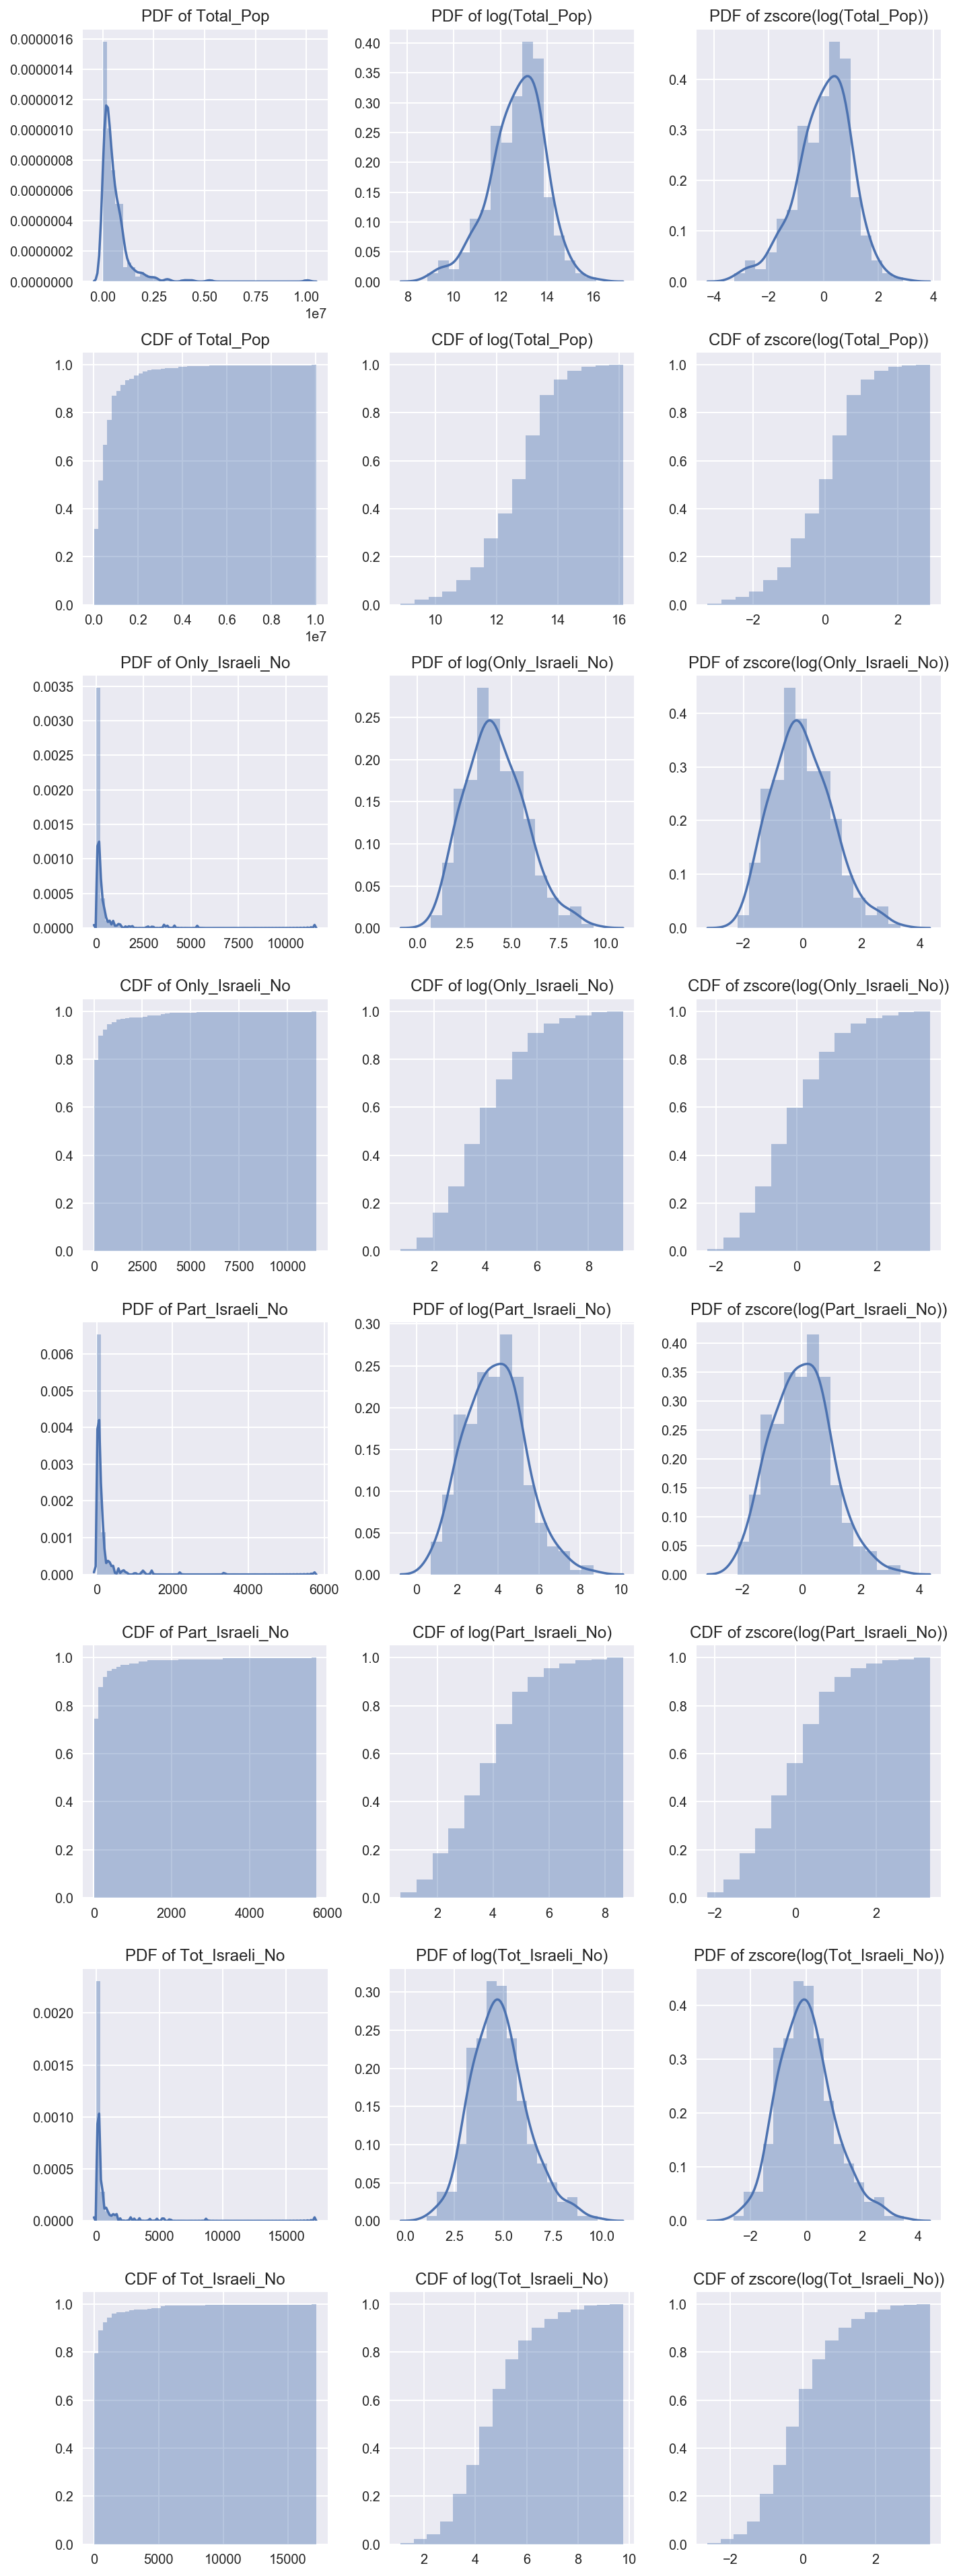

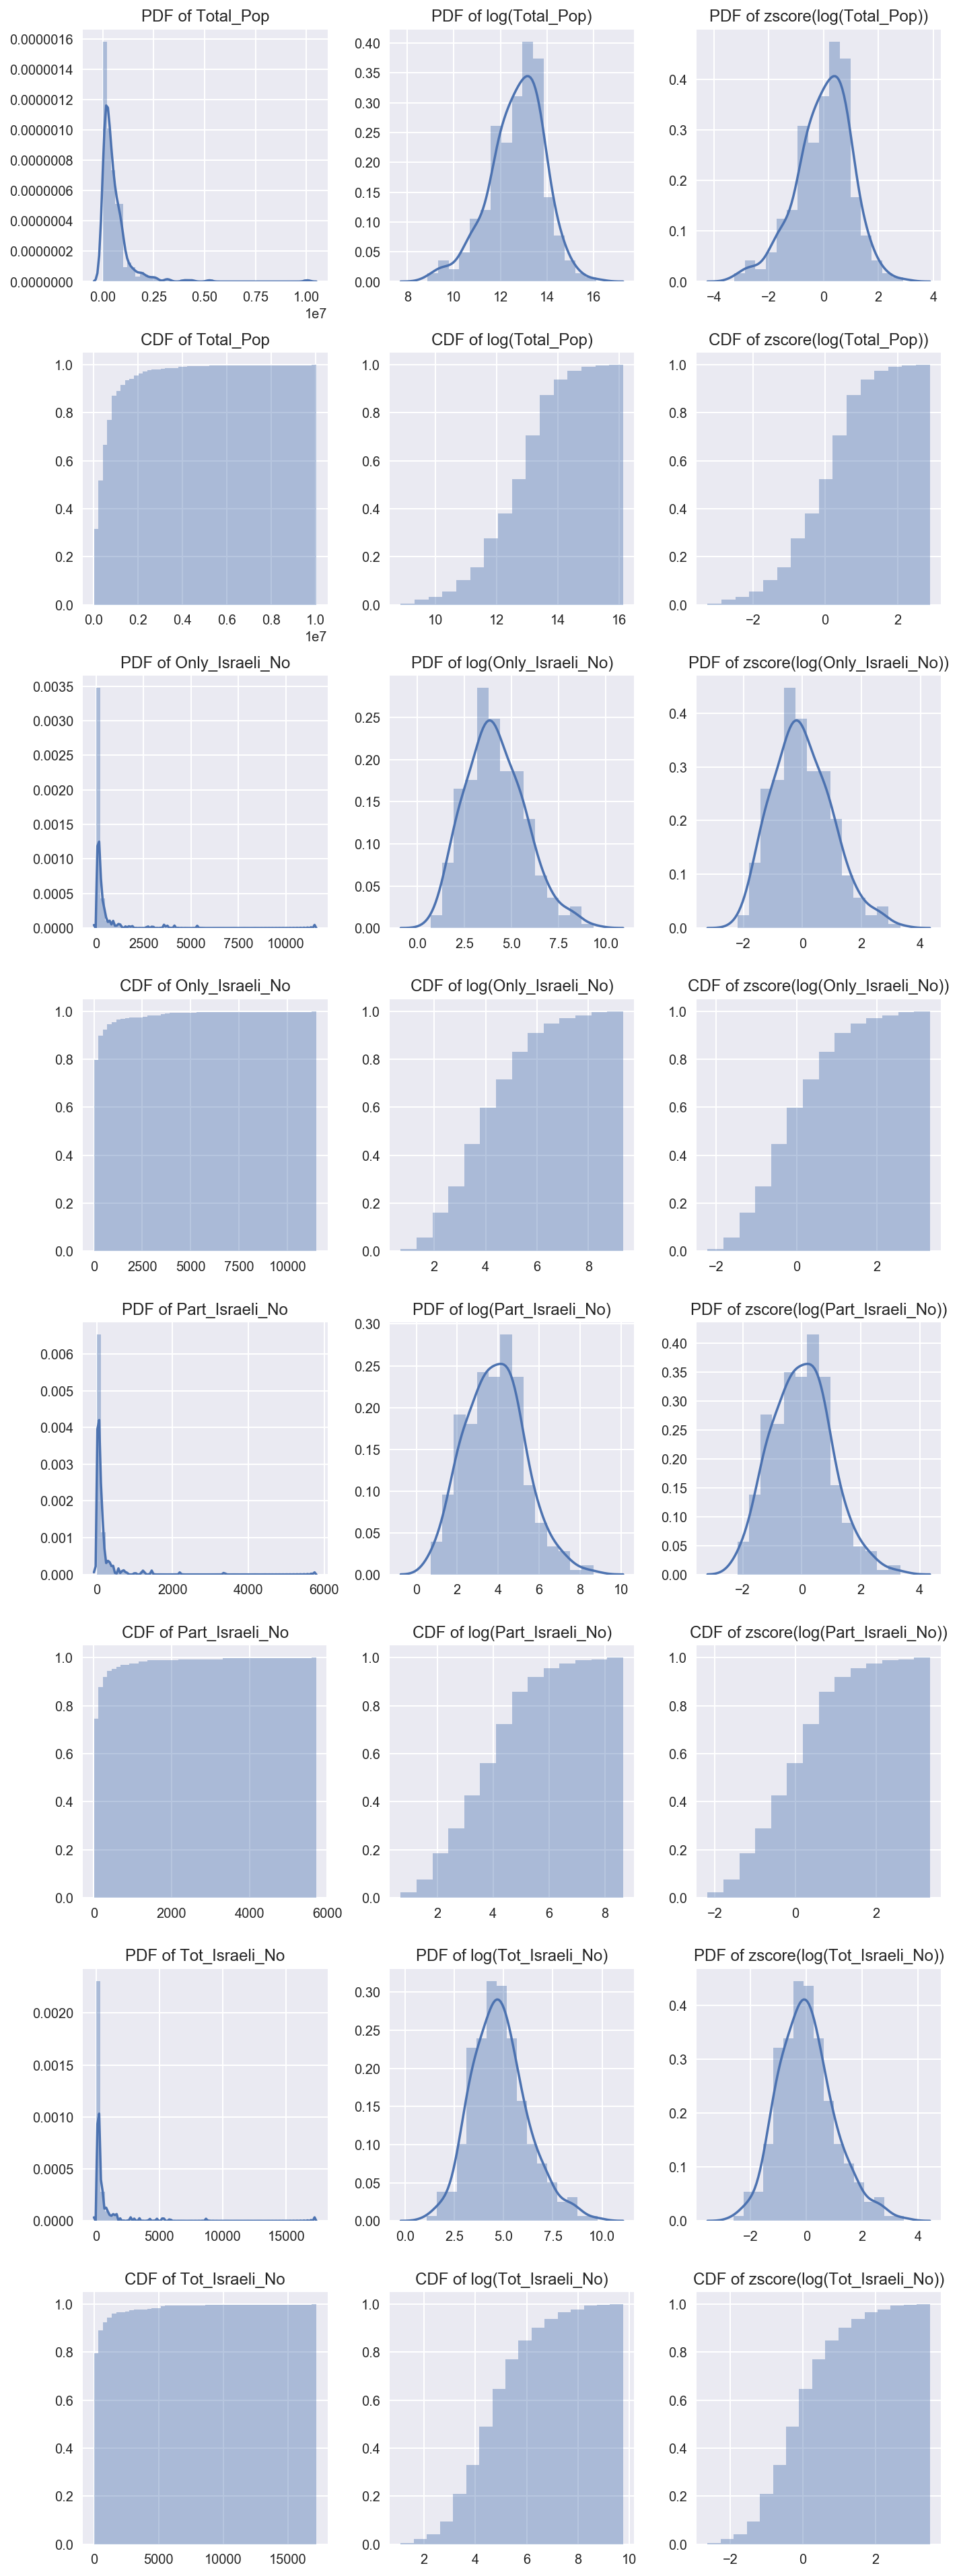

In [5]:


def plot_pmf_cdf_scaled(df):
    """Plot PDFs and CDFs of features at different scales."""
    df = df.select_dtypes([float, int])
    
    N_COLS = 3  # num of different scales
    ROWS_PER_FEAT = 2  # one for PDFs, the other for CDFs
    
    n_rows = df.shape[1]*2
    fig_width = 10
    fig_height = fig_width*n_rows/N_COLS

    cdf_hist_kws = dict(cumulative=True, normed=True)
    
    fig, axes = plt.subplots(n_rows, N_COLS, figsize=(fig_width, fig_height))
    
    for i, (name, col) in zip(range(0, n_rows, ROWS_PER_FEAT), df.items()):

        data = col

        title = 'PDF of {}'.format(name)
        ax = sns.distplot(data, ax=axes[i, 0])
        _ = ax.set_title(title)
        _ = ax.set_xlabel('')

        title = 'CDF of {}'.format(name)
        ax = sns.distplot(data, ax=axes[i+1, 0], kde=False,
                          hist_kws=cdf_hist_kws)
        _ = ax.set_title(title)
        _ = ax.set_xlabel('')

        # log values
        data = np.log(col+1)

        title = 'PDF of log({})'.format(name)
        ax = sns.distplot(data, ax=axes[i, 1])
        _ = ax.set_title(title)
        _ = ax.set_xlabel('')

        title = 'CDF of log({})'.format(name)
        ax = sns.distplot(data, ax=axes[i+1, 1], kde=False,
                          hist_kws=cdf_hist_kws)
        _ = ax.set_title(title)
        _ = ax.set_xlabel('')

        # standardized log values
        data = sklearn.preprocessing.StandardScaler().fit_transform(
                   np.log(col+1).values.reshape(-1, 1))

        title = 'PDF of zscore(log({}))'.format(name)
        ax = sns.distplot(data, ax=axes[i, 2])
        _ = ax.set_title(title)
        _ = ax.set_xlabel('')

        title = 'CDF of zscore(log({}))'.format(name)
        ax = sns.distplot(data, ax=axes[i+1, 2], kde=False,
                          hist_kws=cdf_hist_kws)
        _ = ax.set_title(title)
        _ = ax.set_xlabel('')
        
        plt.tight_layout()
        
    return fig

plot_pmf_cdf_scaled(
    acs_df.select(lambda x: not x.endswith('_Pc'), axis=1)
)

In [6]:
sample = acs_df.sample(4, random_state=42)
sample

,County,State,Total_Pop,Only_Israeli_No,Only_Israeli_Pc,Part_Israeli_No,Part_Israeli_Pc,Tot_Israeli_No,Tot_Israeli_Pc
FIPS,,,,,,,,,
39095,Lucas County,OH,436261,64,0.014670,36,0.008252,100,0.022922
06015,Del Norte County,CA,27788,16,0.057579,13,0.046783,29,0.104362
12071,Lee County,FL,663675,102,0.015369,80,0.012054,182,0.027423
12085,Martin County,FL,151586,25,0.016492,40,0.026388,65,0.042880


In [7]:
sample_fips = sample.index.tolist()

In [8]:
sample_zips = (zips_fips.groupby('FIPS')
               .filter(lambda gr: gr.name in sample_fips))

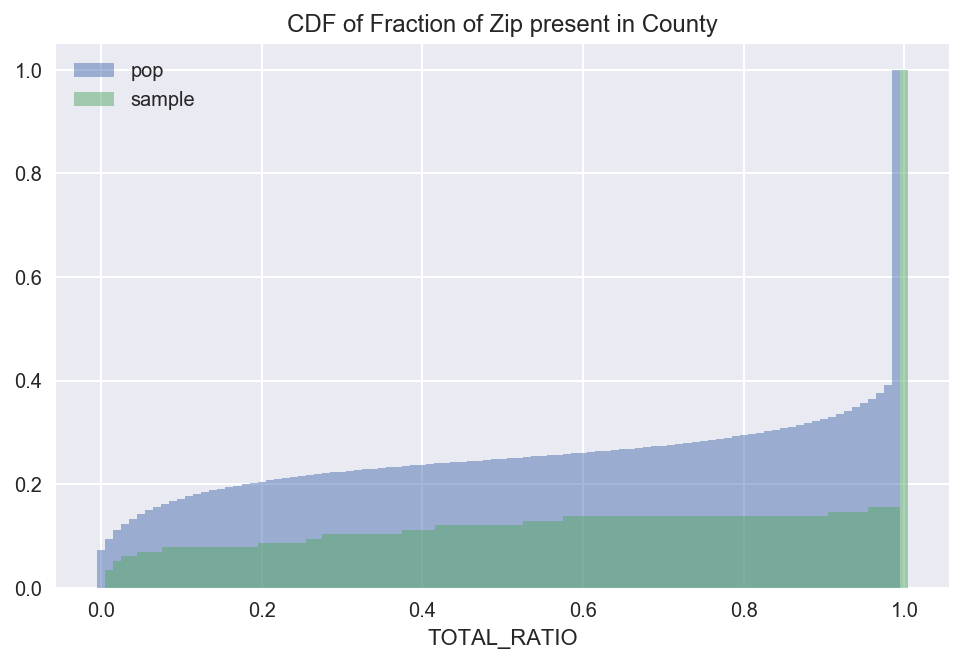

In [9]:
fig = plt.figure(figsize=(8, 5))

cdf_kwargs = dict(bins=100, cumulative=True, normed=True,
                  histtype='bar', alpha=.5)
plt.hist(zips_fips.TOT_RATIO, label='pop', align='left', **cdf_kwargs)
plt.hist(sample_zips.TOT_RATIO, label='sample', align='right', **cdf_kwargs)

plt.legend(loc='best')
plt.title('CDF of Fraction of Zip present in County')
plt.xlabel('TOTAL_RATIO')

plt.show()

In [10]:
zips_fips[zips_fips.TOT_RATIO<.5].shape, zips_fips.shape

((12956, 6), (52318, 6))

Only take zips within a county above a certain threshold

In [11]:
THRESH = .5
perc_zips = 100 - percentileofscore(sample_zips.TOT_RATIO, THRESH)
print('{:f}% of zips above thresh {}'.format(perc_zips, THRESH))

87.931034% of zips above thresh 0.5


In [12]:
sample_zips[sample_zips.TOT_RATIO>.9].shape

(100, 6)

In [13]:
test_zips = sample_zips.loc[sample_zips.TOT_RATIO>=THRESH, 'ZIP']

In [14]:
test_zips.to_csv(TEST_SAMPLE_FP, index=False)